# Estimating a model with a known number of events

This section will show you how to estimate a single HMP model with a given number of events, as in the previous tutorial, but now we'll make it more realistic and harder to discover.

First we do more or less the same as in the previous tutorial:
- simulate EEG data
- transform the data
- initialize a model with default parameters for distribution, shape and event duration

We now simulate the data by calling the `demo` function, which is only used for this tutorial.

In [1]:
import sys
sys.path.insert(0, "/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp")

%load_ext autoreload
%autoreload 2

In [2]:
## Importing the package
import hmp
#Plotting 
import numpy as np
import matplotlib.pyplot as plt

cpus = 5 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM
import multiprocessing as mp
#When using multiple CPUs explicitely setting the context of the multiprocessing is needed
#The following line works in most environment
mp.set_start_method("spawn")
#If multiprocessing errors/warning still present comment previous line and uncomment this one
# mp.set_start_method("fork")


## Running the demo function in the simulation module
# Inspect the given function to apply your own simulations
from hmp.simulations import demo
n_events = 8 #how many events to simulate
epoch_data, sim_source_times, info = demo(cpus, n_events)

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:163: UserWarning: ./dataset_tutorial2_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Processing participant ./dataset_tutorial2_raw.fif's continuous eeg
Reading 0 ... 291539  =      0.000 ...   485.401 secs...


/home/gweindel/miniconda3/envs/main_hmp/lib/python3.12/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


50 trials were retained for participant ./dataset_tutorial2_raw.fif


We specify directly that we want 4 PC components:

In [3]:
hmp_dat = hmp.utils.transform_data(epoch_data, n_comp=4)
print(hmp_dat)

<xarray.DataArray (component: 4, all_samples: 40740)> Size: 1MB
array([[-0.59103095, -0.32212441, -0.42691323, ...,  0.51562066,
         0.5161034 , -0.08296609],
       [-0.28945921, -0.45681239, -0.33510178, ...,  0.4054105 ,
         0.41594636,  0.17958147],
       [ 0.12365175,  1.13944673,  0.48694969, ..., -0.67847307,
        -0.26960778, -0.1218362 ],
       [-0.5015595 , -0.79538873, -1.56399708, ...,  1.61294536,
         1.39095762,  0.71608106]])
Coordinates:
    event_name   (all_samples) object 326kB 'stimulus' 'stimulus' ... 'stimulus'
    rt           (all_samples) float64 326kB 1.059 1.059 1.059 ... 1.094 1.094
  * component    (component) int64 32B 0 1 2 3
  * all_samples  (all_samples) object 326kB MultiIndex
  * participant  (all_samples) <U2 326kB 'S0' 'S0' 'S0' 'S0' ... 'S0' 'S0' 'S0'
  * epochs       (all_samples) int64 326kB 0 0 0 0 0 0 0 ... 49 49 49 49 49 49
  * samples      (all_samples) int64 326kB 0 1 2 3 4 5 ... 652 653 654 655 656
Attributes:
    pca_we

And we initialize the model:

In [4]:
init = hmp.models.hmp(hmp_dat, epoch_data, sfreq=epoch_data.sfreq, event_width=50, cpus=cpus)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one hmp model with a specified number of transition events

## Direct estimation
As in the previous tutorial, we can simply call the ```fit_single``` method from the hmp class to estimate a given number of events. The hmp algorithm will then look for ```n_event``` events. 

Unfortunately, the expectation maximization algorithm to fit the model is sensitive to the starting points given to the relative event onsets. By default, the ```fit_single``` method uses a starting point where all events are equally distributed between 0 and the mean RT, and the magnitudes are set to 0.

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


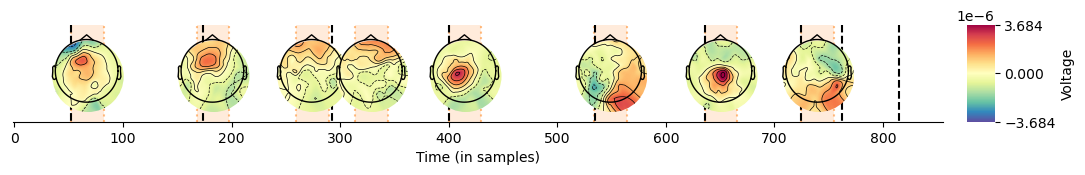

In [4]:
#Fitting
selected = init.fit_single(n_events)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As you can see, the method discovers 8 events - as we told it to - but one of them is at the wrong location (the vertical lines indicate the true event locations).

Thus, launching a single model without additional starting points is not a good idea as sometimes the default starting values of the expectation maximization algorithm will end up in a local minima, as above.

To see what happens if we just use the default inputs and set maximization to False:

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


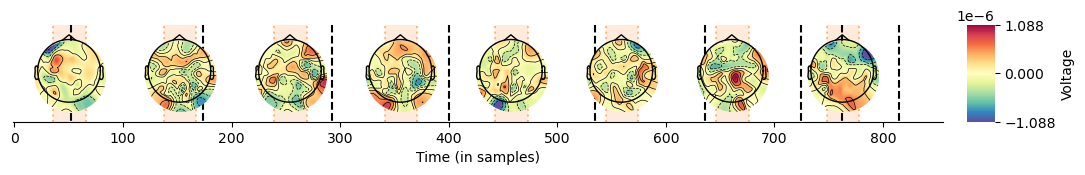

In [5]:
#Fitting
selected = init.fit_single(n_events, maximization=False)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As expected, the 'discovered' events are divided equally over the mean RT. The magnitudes are not 0, as we're plotting the average EEG data at the discovered time points in each trial - as you can see these averages are quite random, and also have very small amplitudes compared to the graph above.

The lesson we learned: we need to use more starting points!

### Exercise 1:

Adapt the cell below to generate starting points on the scale of the gamma parameters to capture all those events. Compare the discovered events to the vertical lines - the onset of the events should overlap with the lines.

Keep in mind that the mean of a gamma is _scale * shape_ 

In [6]:
pars = np.reshape(np.concatenate([
    np.repeat(init.shape, 9), 
    #Following values are our starting points for the between event durations
    [10,10,10,10,10,10,10,10,10]]),#Replace values here- for the exercise
    [2,9]).T
pars

array([[ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.],
       [ 2., 10.]])

Estimating 8 events model
parameters estimated for 8 events model


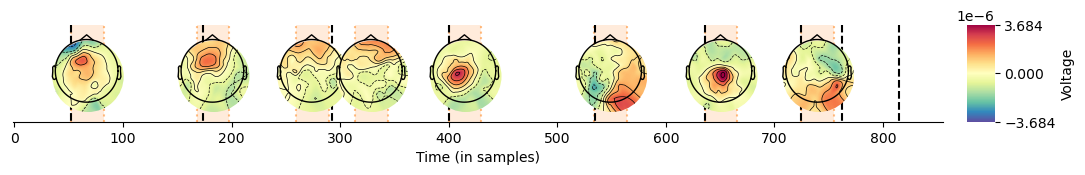

In [7]:
#Fitting
selected = init.fit_single(n_events, parameters=pars)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

## Random method

In reality, we do not know where the real events are. Thus, a better idea is to run a single model with several starting points and selecting the result with the best fit. This can be declared in the ```single_fit()``` function; here we estimate an example with 50 random starting points. We set `return_max` to False to get all models back, instead of only the winning one. 

We then sort the models by log-likelihood - how well they explain the EEG data - and plot every 5th model.

Estimating 8 events model with 50 starting point(s)


  0%|          | 0/50 [00:00<?, ?it/s]

parameters estimated for 8 events model


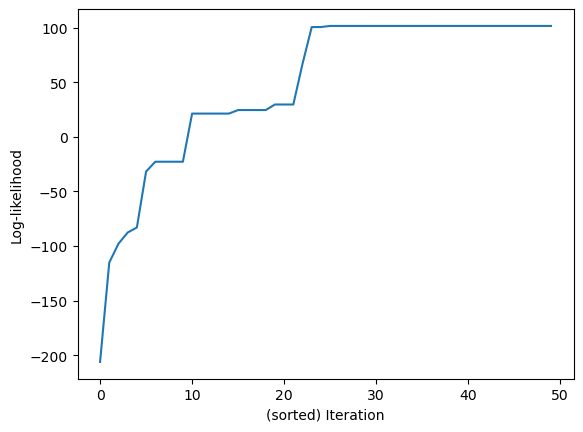

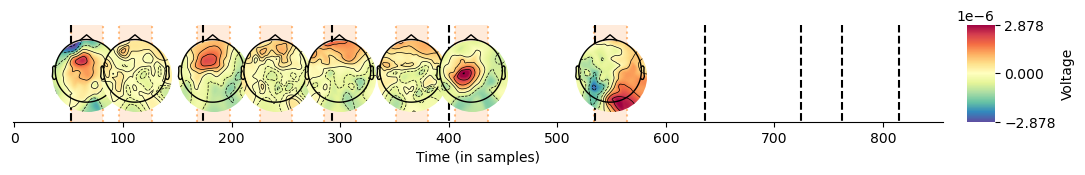

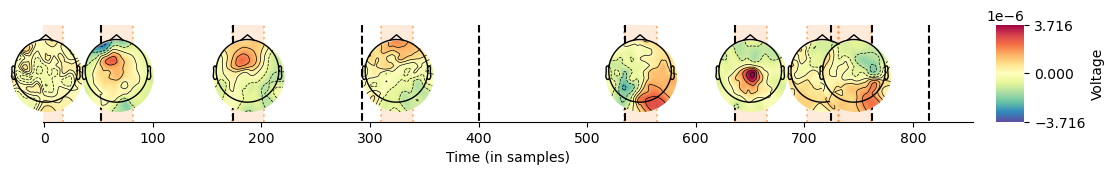

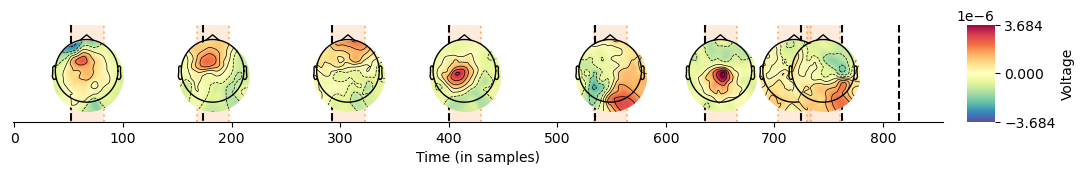

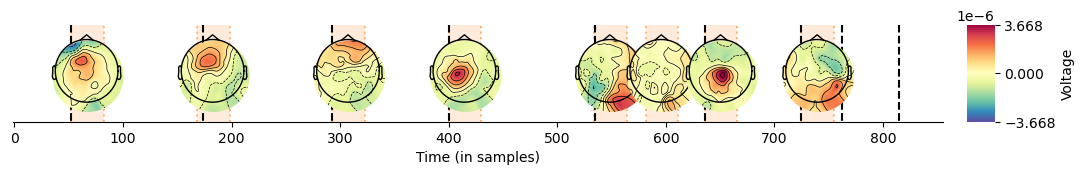

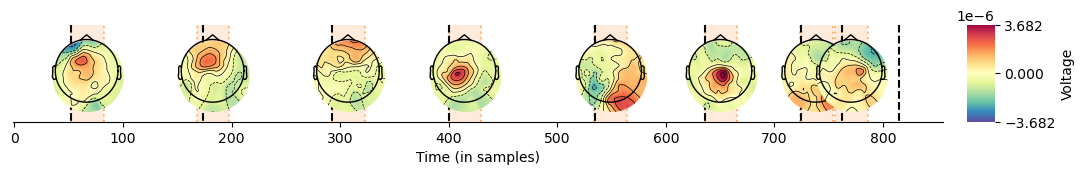

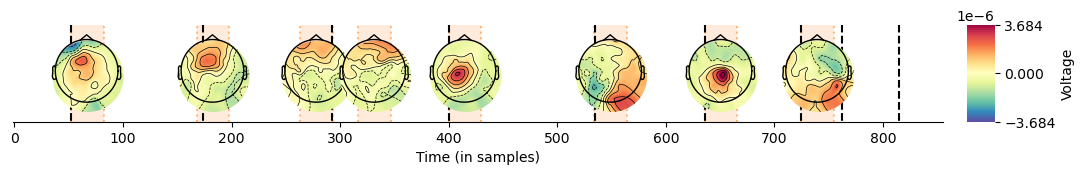

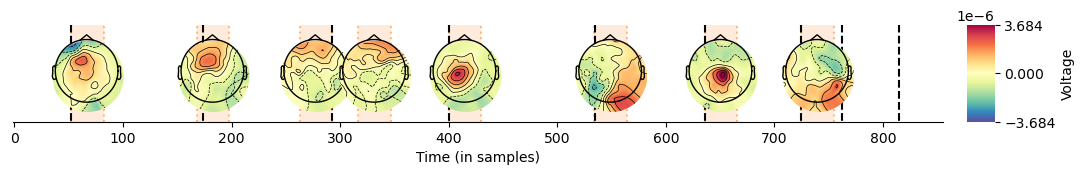

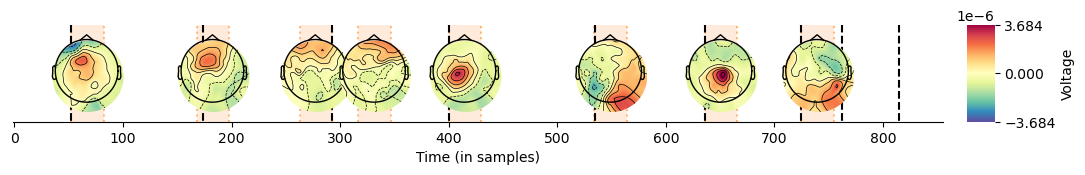

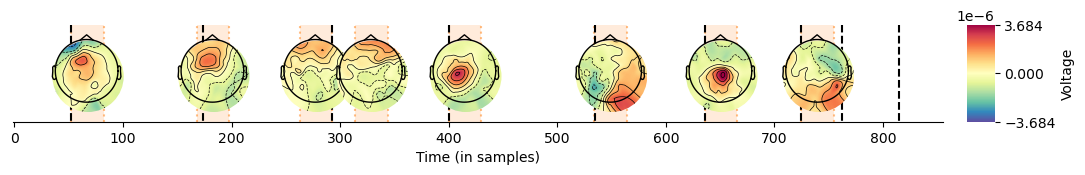

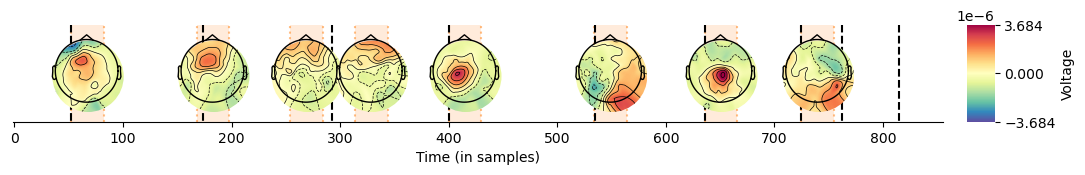

In [8]:
#NOTE: if you run this in VS code on a Mac in an interactive window, you might get strange behavior (running of previous processes) due to the multiprocessing. If so, set your multiprocessing start method to 'fork' (which is the default on Unix) by uncommenting the next two lines:
#import multiprocessing as mp
#mp.set_start_method("fork")

# Fitting
selected = init.fit_single(n_events, method='random', starting_points=50,
                           return_max=False)#function to fit an instance of a 4 events model

plt.plot(selected.sortby('likelihoods').likelihoods)#Sorted starting point iteration based on log-likelihood
plt.xlabel('(sorted) Iteration')
plt.ylabel('Log-likelihood')
for iteration in selected.sortby('likelihoods').iteration[::5]:#Only plot every 5 model
    hmp.visu.plot_topo_timecourse(epoch_data, selected.sel(iteration=iteration), info, init, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As you can see, the higher the likelihood, the closer the discovered events are to the real events. As a side note, instead of recording all those starting points we can just take the most likely one directly by setting `return_max` to True.

But, by definition, the starting points are random: as a result they induce a lot of redundancy and you take the risk that some points in the parameter space remain unexplored. Several calls to this function will not always give the correct solution if not enough starting points have been provided. Below we will explore better/additional solutions to this issue.

### Exercise 2:

What good solution for this can you think of? To illustrate where we are going to do, fit models by subsampling from 1 to 12 events (e.g. 2, 4, 10, 12) with default starting points.

Estimating 2 events model with 1 starting point(s)
parameters estimated for 2 events model


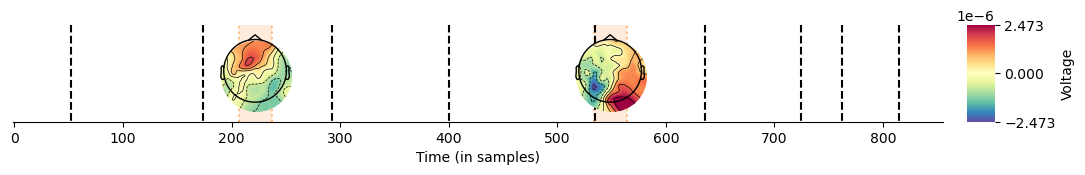

In [9]:
selected = init.fit_single(2)#Replace 2 with the desired number
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

## Backward estimation

Another solution than using random points is to first estimate a model with the maximal number of possible events that fit in RTs (referred to as 'the maximal model'), and then decrease the number of events one by one.

The idea is that genuine events will necessarily be found at the expected locations in the maximal model. Because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remain even if their location would have been hard to find with a single fit and default starting values.

In order to do this we will use the ```backward_estimation()``` function. This function first estimates the maximal model (defined based on the event width and the minimum reaction time), then estimates the max_event - 1 solution by iteratively removing one of the events and picking the next solution with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution is reached. 

In [ ]:
%%time 
bests = init.backward_estimation(max_events=int(init.compute_max_events()))#here we take the floor division by 2 to go faster

Estimating all solutions for maximal number of events (22) with 1 pre-defined starting point and 0 random starting points
Previous model did not fit well. Estimating a neutral 21 event model.
Estimating 21 events model with 1 starting point(s)
parameters estimated for 21 events model
Estimating all solutions for 20 events
Estimating all solutions for 19 events
Estimating all solutions for 18 events
Estimating all solutions for 17 events
Estimating all solutions for 16 events


Here we plot the resulting solutions going from the maximal possible number of events (16) all the way to a single event. 

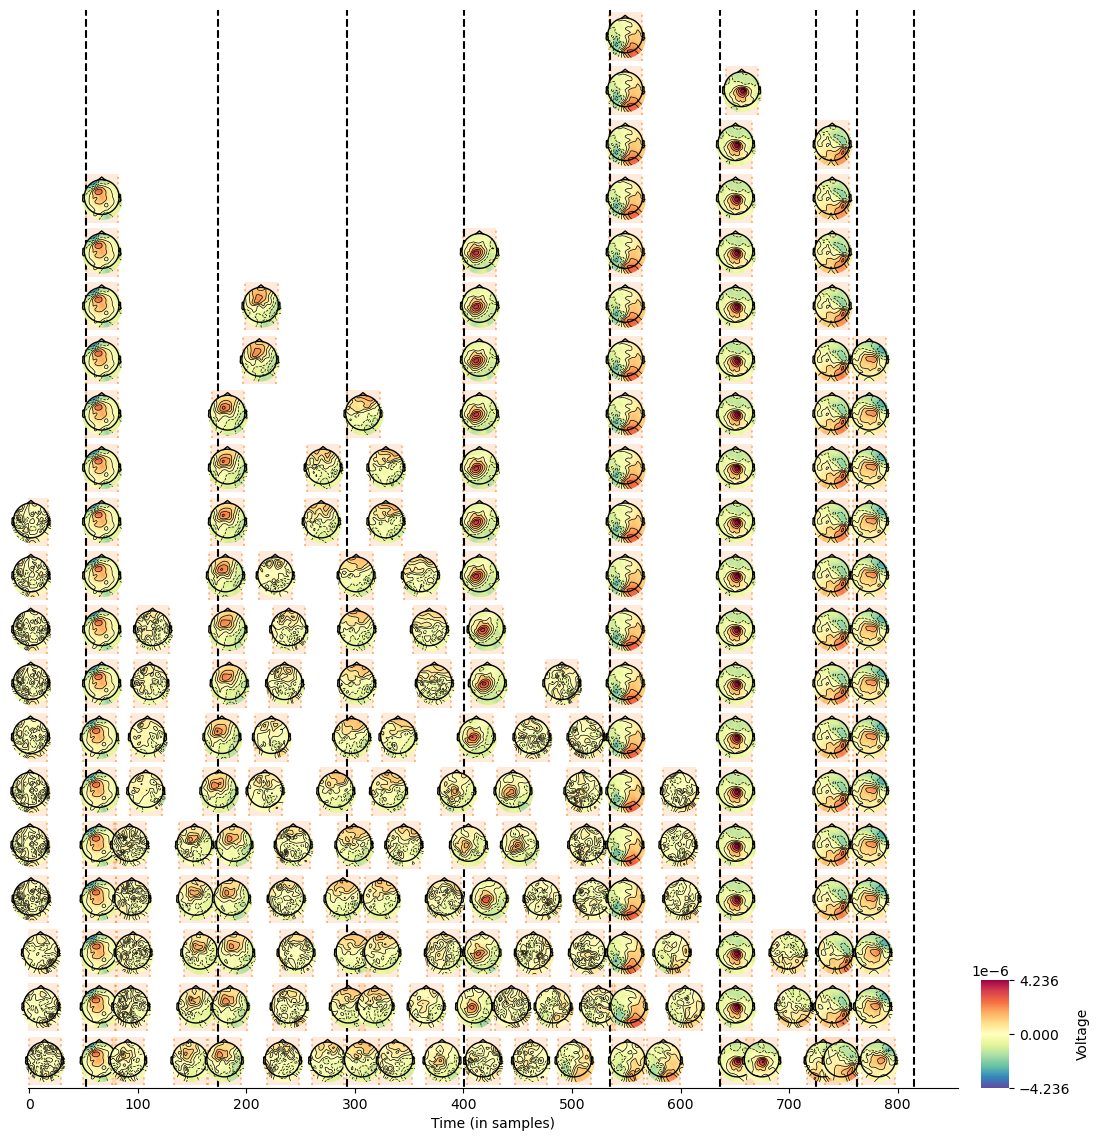

In [8]:
hmp.visu.plot_topo_timecourse(epoch_data, bests, info, init, sensors=False,
                    times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

As you can see, the 15-event solution finds the real events + some extra ones (which typically look very weak). From these solutions we can select the number of events we originally wanted to estimate (which is the correct solution in this case):

In [ ]:
selected = bests.sel(n_events=n_events)
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

The downside is that we are still unsure about whether we included all possible starting points in the mix. In addition, this method can be suboptimal with 1) long RTs and therefore a lot of events to fit and long computation times and 2) if there is a big difference between the minimum RT (determining the maximum number of events) and the mean RT (all possible locations of these events).

## Cumulative event fit

Instead of fitting an _n_ event model this method starts by fitting a 1 event model using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as a starting points reaches the convergence criterion, the function fits an _n+1_ event model and uses the next samples in the RT for the following event, etc.

In [ ]:
estimates = init.fit(diagnostic=True)

In [ ]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

Almost perfect but we're missing one! This comes as the EM algorithm might skip a convergence point as it jumps from one local minima to the other because the next one had a higher likelihood (see the orange EM curve). To overcome this we can use the ```by_sample``` method that re-test samples between local convergence point to check for additional missed events. See for example:

In [ ]:
estimates = init.fit(diagnostic=True, by_sample=True)

In [ ]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

Now it's perfect!

# Data saving

Once finished we can save fitted models using the dedicated command

In [ ]:
hmp.utils.save_fit(selected, 'selected.nc')

And load the same way

In [ ]:
estimates = hmp.utils.load_fit('selected.nc')

Or even only save the estimated event probabilities 

In [ ]:
hmp.utils.save_eventprobs(selected.eventprobs, 'selected_eventprobs.nc')